In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import cycxchg as cxc

# Random Geometric Graphs
Here we do a study of the growth of the relevant cycles in random geometric graphs. This is used to show the number of relevant cycles grows much faster with respect to cycle length than minimum cycle bases.

First, we show the algorithmic construction of these graphs and a visual example of a random geometric graph. Our code adapts the random geometric graph code from NetworkX to have periodic boundary conditions to more closely match MD simulations.

In [3]:
def d_per(p1,p2):
    # periodic distance
    aux = np.abs(p1 - p2) # elementwise differences
    aux = np.minimum(aux, 1-aux) # map periodic differences
    return np.linalg.norm(aux)

def random_geometric_graph_periodic(n, radius, dim=2):
    """
    Generates a random geometric graph with periodic boundary conditions.

    Args:
        n (int): Number of nodes.
        radius (float): Connection radius.
        dim (int): Dimension of the space (e.g., 2 for a 2D unit square).
        seed (int, optional): Seed for random number generation.

    Returns:
        networkx.Graph: A random geometric graph with periodic boundaries.
    """
    # 1. Node Placement: Place nodes uniformly in the unit cube
    pos = np.random.rand(n, dim)
    # Make networkx construct interior edges - uses trees to be more efficient than O(n choose 2) operation
    G = nx.random_geometric_graph(n,radius,dim=3,pos={u:pos[u] for u in range(n)})

    # add edges as a consequence of periodic boundaries - fewer boundary edges so this is fairly efficient
    Edges_P = []
    for axis in range(dim):
        # nodes sufficiently close to each boundary
        left = [i for i in range(n) if pos[i][axis]<radius]
        right = [j for j in range(n) if pos[j][axis]>1-radius]
        # add those that are actually close enough together
        Edges_P.extend([(i,j) for i in left for j in right if d_per(pos[i],pos[j])<radius])
    G.add_edges_from(Edges_P)
    
    return G

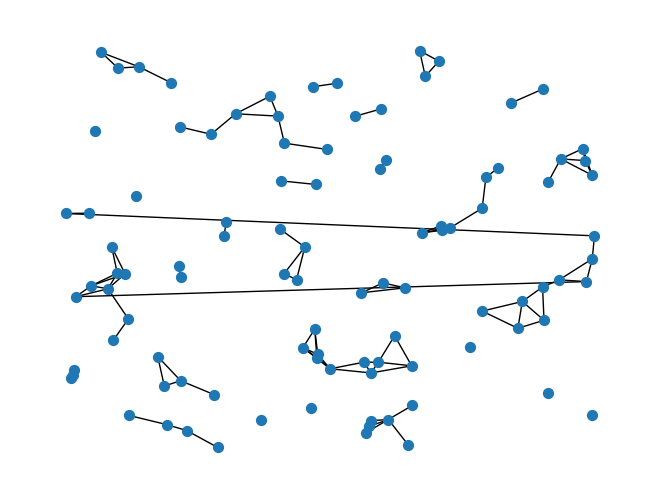

In [18]:
# visualize of a 2D graph 2ith mean degree 2
n,k=100,2 # num. nodes, mean degree
G = random_geometric_graph_periodic(n,(k/(n-1)/np.pi)**(1/2))
nx.draw(G,pos=nx.get_node_attributes(G,'pos'),node_size=50)

## Sampling of geometric graphs
We sample with $N=10^2,10^3,10^4$ a total of $4\times 10^5,4\times 10^4, 4\times 10^3$. The time complexity to generate a random geometric graph is $O(N)$, but the time to sample its relevant cycles is roughly $O(N^2)$.

In [ ]:
# initialize cycle counts
# 3 values of N, 1000 is the maximum cycle length
Len_Dist_Rel = np.zeros((3,1000)) # loop length distribution relevant cycles
Len_Dist_MCB = np.zeros((3,1000)) # loop length distribution minimum cycle basis
Trials_by_n  = np.zeros(3)        # number of samples for each value N

In [32]:
# either read or write results to file
mode = 'r'
if mode == 'w': # write
    np.savez('data/RGG_Loop_Lengths/RGG_Length_Dists.npz',Len_Dist_Rel=Len_Dist_Rel,Len_Dist_MCB=Len_Dist_MCB,Trials_by_n=Trials_by_n)
elif mode == 'r': # read
    loaded_data = np.load('data/RGG_Loop_Lengths/RGG_Length_Dists.npz')
    Len_Dist_Rel = loaded_data['Len_Dist_Rel']
    Len_Dist_MCB = loaded_data['Len_Dist_MCB']
    Trials_by_n  = loaded_data['Trials_by_n']

In [ ]:
# Compute the length dists if they are not in memory
t0 =time.time()
for idx_n,(n,Trials) in enumerate([[100,400000-Trials_by_n[0]],[1000,40000-Trials_by_n[1]],[10000,4000-Trials_by_n[2]]]):
    k = 3 # mean degree
    for i in range(Trials):
        Trials_by_n[idx_n]+=1
        if idx_n>1 or (idx_n==1 and i%100==0) or i%1000==0:
            dt = time.time()-t0
            print(f'{i/Trials/3+idx_n/3:4.2f} {dt//60//60:2.0f}h {dt//60%60:2.0f}m {dt%60:4.1f}s \r',end='')
        radius = (3*k/4/(n-1)/np.pi)**(1/3)
        G=random_geometric_graph_periodic(n, radius, dim=3)
        cyc_dec = cxc.cycle_decomposition(G)
        for TC in cyc_dec.TICE_classes:
            Len_Dist_Rel[idx_n,TC.length]+=TC.num_cycles
        for C in cyc_dec.get_MCB():
            Len_Dist_MCB[idx_n,len(C)]+=1

0.67 12h 11m 47.4s 

In [36]:
print(f'Number of Relevant cycles per node (N=10^4): {sum(Len_Dist_Rel[2,:]/1e4/Trials_by_n[2])}')

Number of Relevant cycles per node (N=10^4): 9926.057698175002


1.403881187213855
3.7694045715660196
16738.730024412333


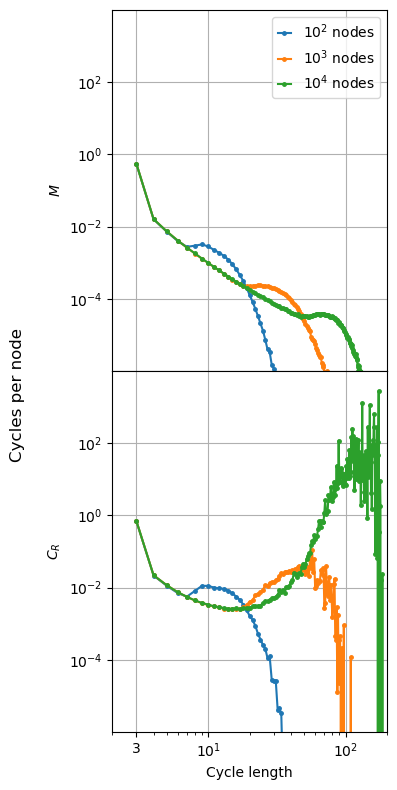

In [46]:
# empty figure
fig,ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(4,8))

# plot data
n_vec = [100,1000,10000]
handles = [0]*3
for i in range(3):
    handles[i] = ax[0].plot(range(3,200),Len_Dist_MCB[i,3:200]/Trials_by_n[i]/n_vec[i],f'.C{i}-',markersize=5)
    ax[1].plot(range(3,200),Len_Dist_Rel[i,3:200]/Trials_by_n[i]/n_vec[i],f'.C{i}-',markersize=5)
    print(sum(Len_Dist_Rel[i,:])/sum(Len_Dist_MCB[i,:]))
# top legend
ax[0].legend([r'$10^2$ nodes',r'$10^3$ nodes',r'$10^4$ nodes'],handlelength=1)
# x axis formatting
plt.xscale('log')
plt.xlim([2,200])
plt.xlabel('Cycle length')
plt.xticks([3,10,100],[3,r'$10^1$',r'$10^2$'])
# y axis formatting
plt.yscale('log')
ax[0].set_ylabel(r'${M}$')
ax[1].set_ylabel(r'${C_R}$')
# plt.yticks([1e-6,1e-3,1,1e3])
plt.yticks([1e-4,1e-2,1,1e2])
plt.ylim([10**(-6),10**(4)])
fig.supylabel(r'Cycles per node')
# grids
ax[0].grid()
ax[1].grid()

# spacing figure
plt.tight_layout()
plt.subplots_adjust(hspace=0)